In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from sklearn.model_selection import train_test_split

In [2]:
def get_data():
    data_dir_path = '/data/ephemeral/home/Dongjin/data/DVM-CAR/data'
    price_table = pd.read_csv(data_dir_path + '/Price_table.csv')
    sales_table = pd.read_csv(data_dir_path + '/Sales_table.csv')
    ad_table = pd.read_csv(data_dir_path + '/Ad_table (extra).csv')

    price_table['Maker'] = price_table['Maker'].str.upper()
    sales_table['Maker'] = sales_table['Maker'].str.upper()
    ad_table['Maker'] = ad_table['Maker'].str.upper()
    ad_table = ad_table.rename(columns={' Genmodel_ID': 'Genmodel_ID'})

    # 데이터 병합
    df = None

    for i, row in price_table.iterrows():
        Maker = row['Maker']
        Genmodel_ID = row['Genmodel_ID']
        Year = str(row['Year'])

        sales_table_filter = sales_table[
        (sales_table['Maker'] == Maker) &
        (sales_table['Genmodel_ID'] == Genmodel_ID)
        ]

        if Year not in sales_table_filter.columns:
            continue

        sales = sales_table_filter[Year].sum()
        new_row = row.copy()
        new_row['sales'] = sales

        if df is None:
            df = pd.DataFrame([new_row])
        else:
            df.loc[len(df)] = new_row    

    ad_table['nan_count'] = ad_table.isnull().sum(axis=1)
    ad_table_sorted = ad_table.sort_values('nan_count', ascending=True)
    ad_table_drop = ad_table_sorted.drop_duplicates(subset=['Maker', 'Genmodel_ID'], keep='first')

    merged_df = pd.merge(df, ad_table_drop, how='left', on=['Maker', 'Genmodel_ID'])
    merged_df = merged_df.drop(['Adv_ID', 'Adv_year', 'Adv_month', 
                                'Color', 'Reg_year', 'Runned_Miles', 'Price', 
                                'Annual_Tax', 'nan_count', 'Genmodel', ' Genmodel'], axis=1)

    merged_df = merged_df.dropna()
    merged_df['Annual_revenue'] = merged_df['Entry_price'] * merged_df['sales']
    merged_df = merged_df.drop(['sales'], axis=1)

    for col in ['Engin_size', 'Average_mpg', 'Top_speed']:
        merged_df[col] = merged_df[col].str.extract(r'([\d\.]+)', expand=False).astype(float)

    df = merged_df


    stylish_dir_path = '/data/ephemeral/home/Dongjin/data/DVM-CAR/data/car_metric/minicpm-v/stylishness'
    stylish_dicts = {}

    stylish_paths = glob(stylish_dir_path + '/*.csv')
    for stylish_path in stylish_paths:
        df_stylish = pd.read_csv(stylish_path)
        df_stylish = df_stylish[0::2]
        df_stylish = df_stylish.reset_index(drop=True)
        df_stylish['score'] = df_stylish['score'].astype(float)

        Year = int(os.path.splitext(os.path.basename(stylish_path))[0])
        stylish_dicts[Year] = df_stylish.copy()


    for index, row in df.iterrows():
        Year = row['Year']
        Genmodel_ID = row['Genmodel_ID']
        
        if Year not in stylish_dicts:
            continue
        
        df_stylish = stylish_dicts[Year]
        filter_index = df_stylish['image_path'].str.contains(f"${Genmodel_ID}$", regex=False)

        if filter_index.sum() == 0:
            continue

        df.loc[index, 'stylish'] = df_stylish[filter_index].score.mean()

    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [3]:
df = get_data()
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

os.makedirs('data', exist_ok=True)
df_train.to_csv('data/train.csv', index=False)
df_test.to_csv('data/test.csv', index=False)

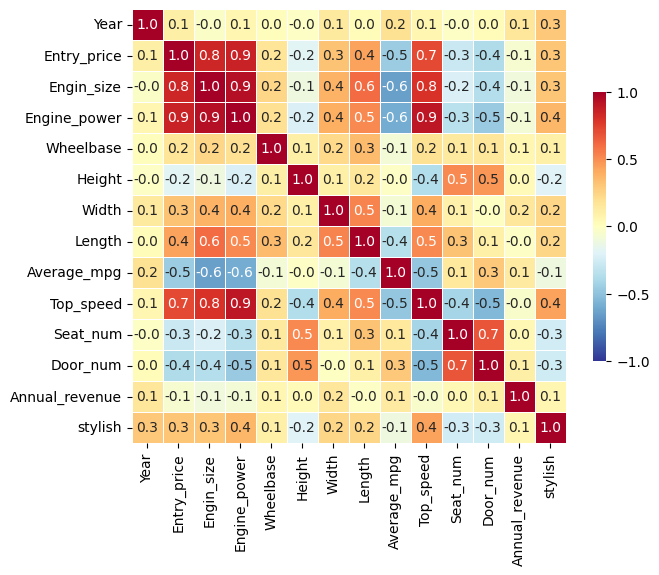

In [4]:
# Correlation map 그리기 
numeric_df = df.select_dtypes(include=[int, float])
corr_df = numeric_df.corr()

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corr_df, cmap='RdYlBu_r', linewidths=0.5, 
            cbar_kws={"shrink": 0.5, "ticks": np.arange(-1, 1.1, 0.5)},
            vmin=-1, vmax=1, square=True, annot=True, fmt='.1f')
plt.show()